<a href="https://colab.research.google.com/github/MassGH2023/Supervised-Machine-Learning-Classification/blob/main/Decision_tree_wine_quality_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Wine_Quality_Data.csv", sep=',')

In [3]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [4]:
data.color = data.color.replace({'white': 0, 'red': 1}).astype(int)

<ipython-input-4-770d4169873c>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.color = data.color.replace({'white': 0, 'red': 1}).astype(int)


` pd.get_dummies(df)` also can be used!




In [5]:
features = [x for x in data.columns if x != 'color']

`['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']`

In [6]:
data.shape

(6497, 13)

The `StratifiedShuffleSplit` object in Scikit-learn splits a dataset into train and test subsets, maintaining the same proportion of classes (the same proportion of `y`) as in the original dataset.

In [7]:
strat_shuff_split = StratifiedShuffleSplit(n_splits= 1, test_size= 1000, random_state= 42)

train_idx, test_idx = next(strat_shuff_split.split(data[features], data['color']))

len(train_idx), len(test_idx)

(5497, 1000)

In [8]:
X_train = data.loc[train_idx, features]
y_train = data.loc[train_idx, 'color']

X_test = data.loc[test_idx, features]
y_test = data.loc[test_idx, 'color']

In [9]:
round(y_train.value_counts(normalize= 1),2)

,proportion
color,
0,0.75
1,0.25


In [10]:
round(y_test.value_counts(normalize= 1),2)

,proportion
color,
0,0.75
1,0.25


In [11]:
dtc = DecisionTreeClassifier(random_state= 42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [12]:
print(f"max depth: {dtc.tree_.max_depth}, number of leaves: {dtc.get_n_leaves()}, count of nodes: {dtc.tree_.node_count}")

max depth: 22, number of leaves: 86, count of nodes: 171


In [13]:
len(dtc.feature_importances_), len(features)

(12, 12)

In [14]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [15]:
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

In [16]:
pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

,train,test
accuracy,0.999818,0.984000
precision,0.999261,0.963710
recall,1.000000,0.971545
f1,0.999631,0.967611


**Using grid search with cross validation**


In [17]:
param_grid={'max_depth': range(1, dtc.tree_.max_depth+1,2), 'max_features': range(1, len(features)+1)}
dtgs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid = param_grid, scoring='accuracy', n_jobs=-1)

In [18]:
dtgs.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 23, 2),
                         'max_features': range(1, 13)},
             scoring='accuracy')

In [19]:
y_train_pred_gr = dtgs.predict(X_train)
y_test_pred_gr = dtgs.predict(X_test)

In [31]:
round(pd.concat([measure_error(y_train, y_train_pred_gr, 'train'), measure_error(y_test, y_test_pred_gr, 'ttest')], axis = 1),2)

,train,ttest
accuracy,1.00,0.99
precision,1.00,0.98
recall,0.98,0.97
f1,0.99,0.98


In [29]:
regfeatures = [x for x in data.columns if x != 'residual_sugar']

In [30]:
X_regtrain = data.loc[train_idx, regfeatures]
y_regtrain = data.loc[train_idx, 'residual_sugar']

X_regtest = data.loc[test_idx, regfeatures]
y_regtest = data.loc[test_idx, 'residual_sugar']


In [33]:
dtreg = DecisionTreeRegressor().fit(X_regtrain, y_regtrain)



In [36]:
param_grid = {"max_depth" :range(1,dtreg.tree_.max_depth+1), 'max_features' :range(1,len(dtreg.feature_importances_)+1)}

In [38]:
dtregGR = GridSearchCV(DecisionTreeRegressor(random_state= 42), param_grid= param_grid, scoring = 'neg_mean_squared_error', n_jobs= -1)

In [39]:
dtregGR = dtregGR.fit(X_regtrain, y_regtrain)

In [40]:
dtregGR.best_estimator_.tree_.node_count, dtregGR.best_estimator_.tree_.max_depth

(8031, 28)

In [42]:
yhat_tr_gr = dtregGR.predict(X_regtrain)
yhat_tst_gr = dtregGR.predict(X_regtest)

In [50]:
pd.Series({'train':mean_squared_error(y_regtrain, yhat_tr_gr), "test":mean_squared_error(y_regtest, yhat_tst_gr)} , name = 'MSE').to_frame().T

,train,test
MSE,0.000052,2.550893


In [61]:
cp = sns.color_palette("dark", 10)
cp

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

In [65]:
plt.style.use("ggplot")

(Text(0.5, 0, 'True'), Text(0, 0.5, 'Predict'))

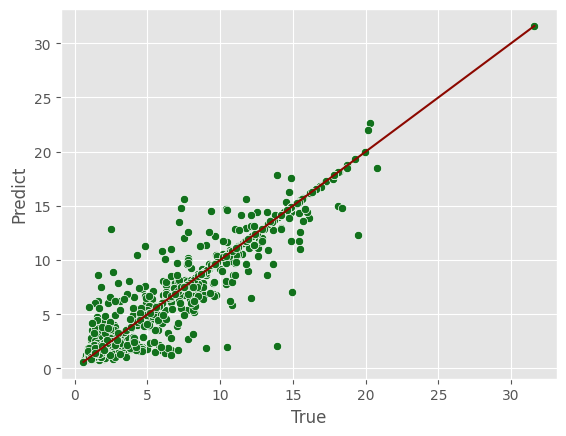

In [66]:
f, a = plt.subplots()
sns.scatterplot(x = y_regtest, y = yhat_tst_gr, color = cp[2] )
sns.lineplot(x = y_regtest, y = y_regtest, ax = a, color = cp[3])
a.set_xlabel('True'), a.set_ylabel('Predict')

In [67]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

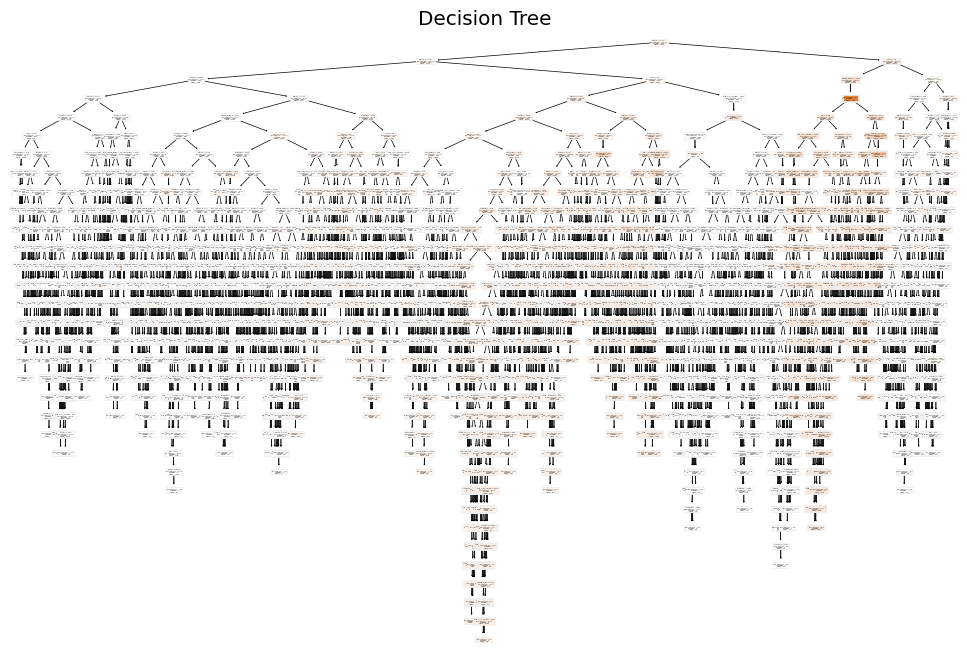

In [69]:
plt.figure(figsize=(12, 8))
plot_tree(dtreg, filled=True, feature_names=regfeatures, class_names=['Low', 'Medium', 'High'])
plt.title('Decision Tree')
plt.savefig('wine_tree.png')  # Save the tree as an image
plt.show()

In [70]:
dtregGR.best_estimator_

DecisionTreeRegressor(max_depth=28, max_features=10, random_state=42)

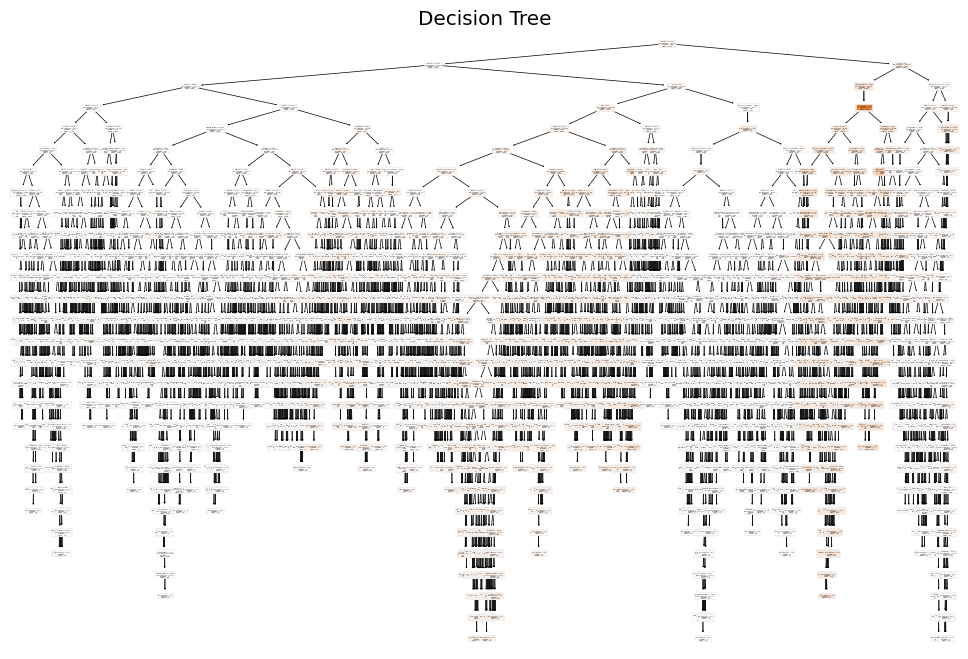

In [71]:
plt.figure(figsize=(12, 8))
plot_tree(dtregGR.best_estimator_, filled=True, feature_names=regfeatures, class_names=['Low', 'Medium', 'High'])
plt.title('Decision Tree')
plt.savefig('wine_tree.png')
plt.show()